In [ ]:
!pip install transformers faiss-cpu datasets flask pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which i

We will use a medical API (Medrxiv) to get medical data in JSON format.

In [ ]:
import requests
import time
import json

# Base URL for the API with a date range
base_url = "https://api.medrxiv.org/details/medrxiv/{start_date}/{end_date}/{cursor}/json"

# Define the date range
start_date = "2012-01-01"
end_date = "2024-12-31"

# Set up the number of papers to download
total_papers = 40000
batch_size = 500
iterations = total_papers // batch_size

# Initial cursor (offset)
cursor = 0

# List to store the papers' metadata
papers = []

# Loop through and fetch the papers
while len(papers) < total_papers:
    # Construct the URL with the cursor value and date range
    url = base_url.format(start_date=start_date, end_date=end_date, cursor=cursor)

    # Make the API request
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()

        # Extend the papers list with the new batch
        papers.extend(data['collection'])

        # Increment the cursor by the number of papers actually retrieved
        cursor += len(data['collection'])

        # Display progress
        print(f"Downloaded {len(papers)} papers so far...")

        # Break if no more papers are retrieved
        if len(data['collection']) == 0:
            break

    else:
        print(f"Failed to retrieve data at cursor {cursor}. Status code: {response.status_code}")
        break

# Save the papers' metadata to a file (optional)
with open("medrxiv_papers_2012_2024.json", "w") as f:
    json.dump(papers, f)

print("Finished downloading papers.")

Downloaded 100 papers so far...
Downloaded 200 papers so far...
Downloaded 300 papers so far...
Downloaded 400 papers so far...
Downloaded 500 papers so far...
Downloaded 600 papers so far...
Downloaded 700 papers so far...
Downloaded 800 papers so far...
Downloaded 900 papers so far...
Downloaded 1000 papers so far...
Downloaded 1100 papers so far...
Downloaded 1200 papers so far...
Downloaded 1300 papers so far...
Downloaded 1400 papers so far...
Downloaded 1500 papers so far...
Downloaded 1600 papers so far...
Downloaded 1700 papers so far...
Downloaded 1800 papers so far...
Downloaded 1900 papers so far...
Downloaded 2000 papers so far...
Downloaded 2100 papers so far...
Downloaded 2200 papers so far...
Downloaded 2300 papers so far...
Downloaded 2400 papers so far...
Downloaded 2500 papers so far...
Downloaded 2600 papers so far...
Downloaded 2700 papers so far...
Downloaded 2800 papers so far...
Downloaded 2900 papers so far...
Downloaded 3000 papers so far...
Downloaded 3100 pap

In [ ]:
import os
import json

# Load JSON data
json_file_path = 'medrxiv_papers_2012_2024.json'
with open(json_file_path, 'r') as f:
    papers_data = json.load(f)

In [ ]:
from datasets import Dataset, DatasetDict

# Create a dictionary for the dataset
data_dict = {
    "doi": [article.get('doi', 'N/A') for article in papers_data],
    "title": [article.get('title', 'N/A') for article in papers_data],
    "authors": [article.get('authors', 'N/A') for article in papers_data],
    "author_corresponding": [article.get('author_corresponding', 'N/A') for article in papers_data],
    "author_corresponding_institution": [article.get('author_corresponding_institution', 'N/A') for article in papers_data],
    "date": [article.get('date', 'N/A') for article in papers_data],
    "version": [article.get('version', 'N/A') for article in papers_data],
    "license": [article.get('license', 'N/A') for article in papers_data],
    "category": [article.get('category', 'N/A') for article in papers_data],
    "abstract": [article.get('abstract', 'N/A') for article in papers_data],
}

# Convert to Hugging Face Dataset
dataset = Dataset.from_dict(data_dict)

# If you want to create a DatasetDict
dataset_dict = DatasetDict({
    "train": dataset
})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['doi', 'title', 'authors', 'author_corresponding', 'author_corresponding_institution', 'date', 'version', 'license', 'category', 'abstract'],
        num_rows: 40000
    })
})


In [ ]:
# Function to count 'N/A' values in each column of a DatasetDict
def count_na_values(dataset_dict):
    na_counts = {}

    for column in dataset_dict['train'].column_names:
        na_count = sum([1 for value in dataset_dict['train'][column] if value == 'N/A'])
        na_counts[column] = na_count

    return na_counts

# Get the count of 'N/A' values in each column
na_counts = count_na_values(dataset_dict)

# Display the counts
print(na_counts)

{'doi': 0, 'title': 0, 'authors': 0, 'author_corresponding': 0, 'author_corresponding_institution': 5, 'date': 0, 'version': 0, 'license': 0, 'category': 0, 'abstract': 0}


We can see that there is only 5 rows with empty values, so we can easily remove these rows without losing any important information.

In [ ]:
# Function to filter out rows with 'N/A' values in any column
def filter_na_values(example):
    # Check if any column in the row contains 'N/A'
    return all(value != 'N/A' for value in example.values())

# Apply the filter to remove entries with 'N/A' values
filtered_dataset = dataset_dict['train'].filter(filter_na_values)

# Replace the original dataset with the filtered one
dataset_dict['train'] = filtered_dataset

# Check the structure of the filtered dataset
print(f"Number of rows in the filtered dataset: {len(dataset_dict['train'])}")

Filter:   0%|          | 0/40000 [00:00<?, ? examples/s]

Number of rows in the filtered dataset: 39995


Now lets check for any duplicated articles and remove them, ensuring unique values.

In [ ]:
def filter_unique_abstracts(example, seen_abstracts=set()):
    """Filter out examples with duplicate abstracts based on the first 100 characters."""
    abstract_snippet = example['abstract'][:100]
    if abstract_snippet in seen_abstracts:
        return False
    seen_abstracts.add(abstract_snippet)
    return True

# Apply the filter to remove entries with duplicate abstracts
unique_filtered_dataset = dataset_dict['train'].filter(lambda x: filter_unique_abstracts(x))

# Replace the original dataset with the filtered one
dataset_dict['train'] = unique_filtered_dataset

# Check the structure of the filtered dataset
print(f"Number of rows in the filtered dataset: {len(dataset_dict['train'])}")

Filter:   0%|          | 0/39995 [00:00<?, ? examples/s]

Number of rows in the filtered dataset: 30015


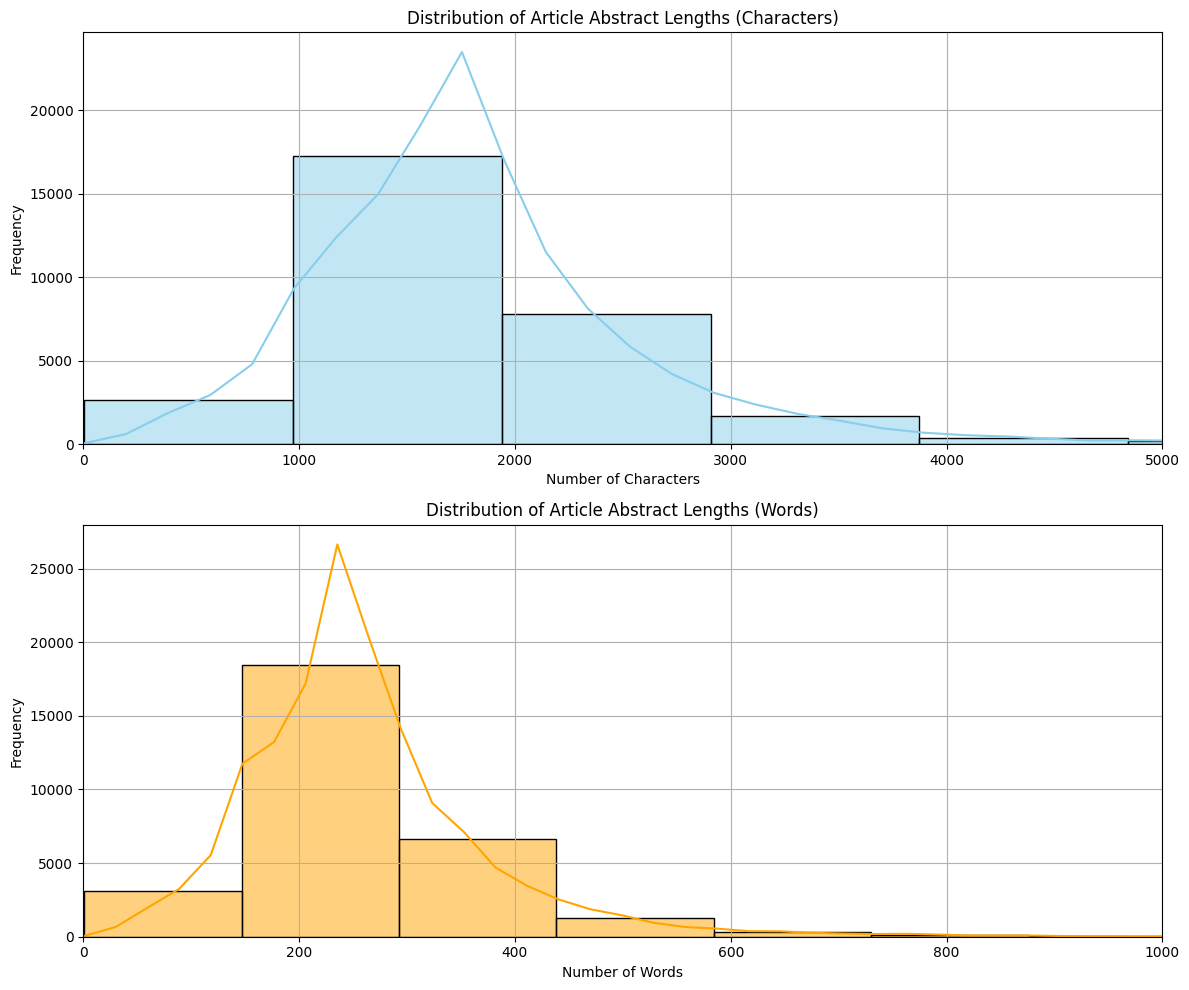

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the length of each article's original text (in characters)
article_lengths = [len(text) for text in dataset_dict['train']['abstract']]

# Extract the number of words in each article's original text
article_word_counts = [len(text.split()) for text in dataset_dict['train']['abstract']]

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plotting the histogram for character count
sns.histplot(article_lengths, bins=40, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Article Abstract Lengths (Characters)')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 5000)  # Set the x-axis limits to focus on 0-5000 characters
axes[0].grid(True)

# Plotting the histogram for word count
sns.histplot(article_word_counts, bins=40, kde=True, color='orange', ax=axes[1])
axes[1].set_title('Distribution of Article Abstract Lengths (Words)')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 1000)  # Adjust this limit based on the distribution of word counts
axes[1].grid(True)

# Adjust layout to make sure plots don't overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
def filter_short_texts(example):
    return len(example['abstract']) >= 200

# Apply the filter to remove entries with short texts
filtered_dataset = dataset_dict['train'].filter(filter_short_texts)

# Replace the original dataset with the filtered one
dataset_dict['train'] = filtered_dataset

# Check the structure of the filtered dataset
print(f"Number of rows in the filtered dataset: {len(dataset_dict['train'])}")

Filter:   0%|          | 0/30015 [00:00<?, ? examples/s]

Number of rows in the filtered dataset: 29994


We will also filter out very long texts, as we plan to truncate the text to include only the first 512 tokens. In very long abstracts, the crucial information might not be captured within the first 512 tokens.

In [ ]:
def filter_long_texts(example):
    return len(example['abstract']) <= 3000

# Apply the filter to remove entries with short texts
filtered_dataset = dataset_dict['train'].filter(filter_long_texts)

# Replace the original dataset with the filtered one
dataset_dict['train'] = filtered_dataset

# Check the structure of the filtered dataset
print(f"Number of rows in the filtered dataset: {len(dataset_dict['train'])}")

Filter:   0%|          | 0/29994 [00:00<?, ? examples/s]

Number of rows in the filtered dataset: 27921


In [ ]:
# Access the first row in the train dataset
first_row = dataset_dict['train'][0]

# Iterate through all columns and print the values smartly
for column_name, value in first_row.items():
    if isinstance(value, list) and len(value) > 10:  # If the column is a list and has many items, truncate for display
        print(f"{column_name.capitalize()}: {value[:10]}... (truncated, total {len(value)} items)")
    elif isinstance(value, str) and len(value) > 200:  # If the column is a long string, truncate for display
        print(f"{column_name.capitalize()}: {value[:200]}... (truncated)")
    else:
        print(f"{column_name.capitalize()}: {value}")

Doi: 10.1101/19000109
Title: Molecular profiling of neonatal dried blood spots reveals changes in innate and adaptive immunity following fetal inflammatory response
Authors: Daniel Costa; Nuria Bonet; Amanda Sole; Jose Manuel Gonzalez de Aledo-Castillo; Eduard Sabido; Ferran Casals; Carlota Rovira; Alfons Nadal; Jose Luis Marin; Teresa Cobo; Robert Castelo
Author_corresponding: Robert Castelo
Author_corresponding_institution: Department of Experimental and Health Sciences, Universitat Pompeu Fabra (UPF), Barcelona, Spain; Research Programme on Biomedical Informatics, Institut Hospita
Date: 2019-06-25
Version: 1
License: cc_by
Category: genetic and genomic medicine
Abstract: The fetal inflammatory response (FIR) increases the risk of perinatal brain injury, particularly in extremely low gestational age newborns (ELGANs, < 28 weeks of gestation). One of the mechanisms cont... (truncated)


In [ ]:
import tensorflow as tf

# Check if TensorFlow can detect the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Since we are using a medical dataset with many medical words that could be uncommon to a pretrained tokenizer, it is important we train our tokenizer using subword tokenization to learn the best way to tokenize our data.

In [ ]:
from tokenizers import BertWordPieceTokenizer

# Load your medical dataset abstracts
texts = dataset_dict['train']['abstract']

# Initialize the WordPiece tokenizer
tokenizer = BertWordPieceTokenizer(lowercase=True)

# Train the tokenizer on your medical texts
tokenizer.train_from_iterator(
    texts,
    vocab_size=30000,
    limit_alphabet=1000,
    min_frequency=2
)

# Create the directory if it doesn't exist
if not os.path.exists("/content/medical_wordpiece_tokenizer"):
    os.makedirs("/content/medical_wordpiece_tokenizer")

# Save the trained tokenizer
tokenizer.save_model("/content/medical_wordpiece_tokenizer")

['/content/medical_wordpiece_tokenizer/vocab.txt']

In [ ]:
import torch
from transformers import BertTokenizer, TFAutoModel

# Load the custom tokenizer we trained
custom_tokenizer = BertTokenizer.from_pretrained('medical_wordpiece_tokenizer')

# Load the pre-trained BERT model
model = TFAutoModel.from_pretrained('bert-base-uncased')

def cls_pooling(model_output):
    """Extracts the CLS token representation from the last hidden state."""
    return model_output.last_hidden_state[:, 0]

def get_embeddings(text_list):
    """Generates embeddings for a list of texts using the BERT model."""
    encoded_input = custom_tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="tf")
    model_output = model(encoded_input)
    return cls_pooling(model_output).numpy()

def add_embeddings_to_dataset(example):
    """Adds embeddings to each example in the dataset."""
    embeddings = get_embeddings(example["abstract"])
    return {"embeddings": embeddings.tolist()}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Apply the embedding function to the entire dataset
embeddings_dataset = dataset_dict.map(add_embeddings_to_dataset, batched=True, batch_size=4)

# Check the structure of the dataset
print(embeddings_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/27921 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['doi', 'title', 'authors', 'author_corresponding', 'author_corresponding_institution', 'date', 'version', 'license', 'category', 'abstract', 'embeddings'],
        num_rows: 27921
    })
})


In [ ]:
# Add an ID column to the dataset
def add_id_column(batch, idx):
    batch['id'] = idx
    return batch

# Apply the function to the dataset
embeddings_dataset = embeddings_dataset.map(add_id_column, with_indices=True)

# Check the structure of the dataset
print(embeddings_dataset)

Map:   0%|          | 0/27921 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['doi', 'title', 'authors', 'author_corresponding', 'author_corresponding_institution', 'date', 'version', 'license', 'category', 'abstract', 'embeddings', 'id'],
        num_rows: 27921
    })
})


In [ ]:
# Inspect the first row to see the embeddings and new ID
first_row_with_embeddings = embeddings_dataset['train'][0]

# Iterate through all columns and print the values smartly
for column_name, value in first_row_with_embeddings.items():
    if isinstance(value, list) and len(value) > 10:
        print(f"{column_name.capitalize()}: {value[:10]}... (truncated, total {len(value)} items)")
    elif isinstance(value, str) and len(value) > 200:
        print(f"{column_name.capitalize()}: {value[:200]}... (truncated)")
    else:
        print(f"{column_name.capitalize()}: {value}")

Doi: 10.1101/19000109
Title: Molecular profiling of neonatal dried blood spots reveals changes in innate and adaptive immunity following fetal inflammatory response
Authors: Daniel Costa; Nuria Bonet; Amanda Sole; Jose Manuel Gonzalez de Aledo-Castillo; Eduard Sabido; Ferran Casals; Carlota Rovira; Alfons Nadal; Jose Luis Marin; Teresa Cobo; Robert Castelo
Author_corresponding: Robert Castelo
Author_corresponding_institution: Department of Experimental and Health Sciences, Universitat Pompeu Fabra (UPF), Barcelona, Spain; Research Programme on Biomedical Informatics, Institut Hospita
Date: 2019-06-25
Version: 1
License: cc_by
Category: genetic and genomic medicine
Abstract: The fetal inflammatory response (FIR) increases the risk of perinatal brain injury, particularly in extremely low gestational age newborns (ELGANs, < 28 weeks of gestation). One of the mechanisms cont... (truncated)
Embeddings: [0.40591686964035034, 0.5839108228683472, 0.0022559836506843567, 0.08651416748762131, -0.

In [ ]:
import numpy as np

# Convert the embeddings from the first example to a numpy array to check the shape
embeddings_array = np.array(first_row_with_embeddings['embeddings'])
print("Shape of the embeddings:", embeddings_array.shape)

Shape of the embeddings: (768,)


We can see that the embeddings have indeed worked. We can see the cls pooling our rows where each embedding is a matrix of 768 values.

In [ ]:
embeddings_dataset

DatasetDict({
    train: Dataset({
        features: ['doi', 'title', 'authors', 'author_corresponding', 'author_corresponding_institution', 'date', 'version', 'license', 'category', 'abstract', 'embeddings', 'id'],
        num_rows: 27921
    })
})

Now we can test to see if FAISS works on our embeddings before moving on to web page creation.

In [ ]:
import random

# Define the number of random samples you want to extract
num_samples = 50

# Get the total number of entries in the dataset
total_entries = len(embeddings_dataset['train'])

# Generate random indices
random_indices = random.sample(range(total_entries), num_samples)

# Extract random titles and abstracts based on the random indices
random_titles = [embeddings_dataset['train']['title'][i] for i in random_indices]
random_abstracts = [embeddings_dataset['train']['abstract'][i] for i in random_indices]

# Loop through the random samples and print the title and first 100 characters of each abstract
for i in range(num_samples):
    title = random_titles[i]
    abstract = random_abstracts[i][:100]
    print(f"Title: {title}")
    print(f"Abstract: {abstract}... (truncated)")
    print("-" * 80)

Title: Complement and tissue factor-enriched neutrophil extracellular traps are key drivers in COVID-19 immunothrombosis
Abstract: Emerging data indicate that complement and neutrophils are involved in the maladaptive host immune r... (truncated)
--------------------------------------------------------------------------------
Title: Clinical and Genetic Characteristics of Covid-19 Patients from UK Biobank
Abstract: ObjectiveTo explore both clinical and genetic risk factors for Covid-19 in a cohort from the United ... (truncated)
--------------------------------------------------------------------------------
Title: Strong immunogenicity of heterologous prime-boost immunizations with the experimental vaccine GRAd-COV2 and BNT162b2 or ChAdOx1-nCOV19
Abstract: Here we report on the humoral and cellular immune response in eight volunteers who autonomously chos... (truncated)
--------------------------------------------------------------------------------
Title: Predicting the Clinical Mana

We can see atleast 5 articles about COVID-19, so lets make our search query related to that.

In [ ]:
# Adding a FAISS index to the dataset based on the "embeddings" column
embeddings_dataset['train'].add_faiss_index(column="embeddings")

# Generate an embedding for the input question
question = "Screening and detection of COVID-19 in different parts of the world."
question_embedding = get_embeddings([question])
print("Shape of the question embedding:", question_embedding.shape)

  0%|          | 0/28 [00:00<?, ?it/s]

Shape of the question embedding: (1, 768)


In [ ]:
# Get the 5 nearest examples from the dataset to the question embedding
scores, samples = embeddings_dataset['train'].get_nearest_examples(
    "embeddings", question_embedding, k=5
)

In [ ]:
# Convert the nearest samples to a DataFrame for easy viewing
import pandas as pd
samples_df = pd.DataFrame.from_dict(samples)

# Add the similarity scores to the DataFrame
samples_df["scores"] = scores

# Sort the DataFrame by scores in descending order (most similar examples first)
samples_df.sort_values("scores", ascending=False, inplace=True)

In [ ]:
# Set None to display full content
pd.set_option('display.max_colwidth', None)

# Print the top 5 results
print("Top 5 most similar examples to the question:")
print(samples_df[["title", "abstract", "scores"]].head(5))

Top 5 most similar examples to the question:
                                                                                                                                              title  \
4                                                                           Efficient Prevalence Estimation and Population Screening for SARS-CoV-2   
3                                                                                      Sensitive on-site detection of SARS-CoV-2 by ID NOW COVID-19   
2                                                                Modelling to Predict Hospital Bed Requirements for Covid-19 Patients in California   
1                                                           Seroprevalence of SARS-CoV-2 Antibodies in Seattle, Washington: October 2019-April 2020   
0  mRNA COVID-19 vaccine effectiveness against SARS-CoV-2 infection in a prospective community cohort, rural Wisconsin, November 2020-December 2021   

                                                

We can see that we are indeed getting accurate results. Our search query "Screening and detection of COVID-19 in different parts of the world" yielded highly relevant results. The top 3 results focused on estimating the prevalence of COVID-19 through various screening and detection methods, as well as predictive modeling for healthcare needs related to the pandemic. This indicates that the model is effectively identifying content that aligns with the intended search topic.

Now that we have the basics of searching for the most relevant results, we can proceed with building a simple web application that uses reinforcement learning as a backbone.

In [ ]:
!pyngrok config add-authtoken 2kjyG0g5eCNLVgfDjJUZrylH9aq_2MERJaHLVQtHnyrbx42qx

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok

app = Flask(__name__)

@app.route('/search', methods=['POST'])
def search():
    query = request.json['query']
    query_embedding = get_embeddings([query])

    # Get the 5 nearest examples from the dataset to the question embedding
    scores, samples = embeddings_dataset['train'].get_nearest_examples(
        "embeddings", query_embedding, k=5
    )

    # Convert the nearest samples to a DataFrame for easy viewing
    samples_df = pd.DataFrame.from_dict(samples)

    # Add the similarity scores to the DataFrame
    samples_df["scores"] = scores

    # Sort the DataFrame by scores in descending order (most similar examples first)
    samples_df.sort_values("scores", ascending=False, inplace=True)

    # Convert to list of dicts for easy JSON response
    results = samples_df.to_dict(orient="records")

    return jsonify(results)

@app.route('/')
def home():
    return '''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>AI-Integrated Search Engine</title>
    </head>
    <body>
        <h1>AI-Integrated Search Engine</h1>
        <input type="text" id="query" placeholder="Enter your search query">
        <button onclick="performSearch()">Search</button>

        <h2>Results:</h2>
        <div id="results"></div>

        <script>
            async function performSearch() {
                const query = document.getElementById('query').value;
                const response = await fetch('/search', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/json',
                    },
                    body: JSON.stringify({ query: query }),
                });
                const data = await response.json();
                displayResults(data);
            }

            function displayResults(results) {
                const resultsDiv = document.getElementById('results');
                resultsDiv.innerHTML = '';
                results.forEach((result) => {
                    const resultElement = document.createElement('div');
                    resultElement.innerHTML = `<h3>${result.title}</h3><p>${result.abstract}</p><p>Score: ${result.scores}</p>`;
                    resultsDiv.appendChild(resultElement);
                });
            }
        </script>
    </body>
    </html>
    '''

# Start ngrok to tunnel the Flask app to the public internet
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000/\"")

# Run the Flask app
app.run()

 * ngrok tunnel "NgrokTunnel: "https://5f4c-34-16-135-62.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000/"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:20:49] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:20:50] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:21:03] "POST /search HTTP/1.1" 200 -


![Home Page](https://raw.githubusercontent.com/ali-ma1/FAISS-Reinforcement-Learning-Medical-Search-Engine/main/images/phase1/test_home.png)


We can see that this is a good starting point, as the back-end we have thusfar is correctly connected to the front-end.

Now we will make a cleaner UI using css, javascript, and HTML. We will also make the documents clickable to monitor which documents are clicked the most and which documents people spend the most time on.

In [ ]:
from flask import Flask, request, jsonify, render_template
from pyngrok import ngrok
import re

# Initialize the Flask app
app = Flask(__name__, static_folder='static', template_folder='templates')

@app.route('/')
def home():
    # Render the main search page
    return render_template('index.html')

def extract_title(doc_tag):
    # Extract the title from the <doc> tag using regex
    match = re.search(r'title="([^"]+)"', doc_tag)
    if match:
        return match.group(1)
    return doc_tag

def clean_abstract(abstract):
    # Remove <doc> tags and any extra spaces/newlines
    return re.sub(r'</?doc[^>]*>', '', abstract).strip()

@app.route('/search', methods=['POST'])
def search():
    try:
        query = request.json['query']
        query_embedding = get_embeddings([query])

        # Get the 5 nearest examples from the dataset to the query embedding
        scores, samples = embeddings_dataset['train'].get_nearest_examples(
            "embeddings", query_embedding, k=5
        )

        results = []
        for i in range(len(samples['title'])):
            title = extract_title(samples['title'][i])
            document_id = samples['id'][i]

            # Access other fields using the document ID
            document = embeddings_dataset['train'][document_id]
            abstract = document['abstract']
            doi = document['doi']
            authors = document['authors']
            corresponding_author = document['author_corresponding']
            institution = document['author_corresponding_institution']
            date = document['date']
            version = document['version']
            license = document['license']
            category = document['category']

            results.append({
                "document_id": document_id,
                "title": title,
                "abstract": abstract,
                "scores": float(scores[i]),
                "doi": doi,
                "authors": authors,
                "corresponding_author": corresponding_author,
                "institution": institution,
                "date": date,
                "version": version,
                "license": license,
                "category": category
            })

        # Sort the results by scores in descending order (best match first)
        results.sort(key=lambda x: x['scores'], reverse=True)

        return jsonify(results)

    except Exception as e:
        print(f"Error during search: {e}")
        return jsonify({"error": str(e)}), 500

@app.route('/document/<int:document_id>', methods=['GET'])
def get_document(document_id):
    document = embeddings_dataset['train'][document_id]
    raw_title = document['title']
    original_text = document['abstract']

    # Extract all necessary fields
    clean_title = extract_title(raw_title)
    clean_text = clean_abstract(original_text)
    doi = document.get('doi', 'N/A')
    authors = document.get('authors', 'N/A')
    corresponding_author = document.get('author_corresponding', 'N/A')
    institution = document.get('author_corresponding_institution', 'N/A')
    date = document.get('date', 'N/A')
    version = document.get('version', 'N/A')
    license = document.get('license', 'N/A')
    category = document.get('category', 'N/A')

    return render_template(
        'document.html',
        title=clean_title,
        text=clean_text,
        doi=doi,
        authors=authors,
        corresponding_author=corresponding_author,
        institution=institution,
        date=date,
        version=version,
        license=license,
        category=category
    )

# Start ngrok to tunnel the Flask app to the public internet
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000/\"")

# Run the Flask app
app.run()

 * ngrok tunnel "NgrokTunnel: "https://f7b2-34-16-135-62.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000/"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:30:16] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:30:16] "GET /static/scripts.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:30:16] "GET /static/styles.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:30:17] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:30:25] "POST /search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:31:01] "GET /document/5101 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:31:01] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 20:31:01] "GET /static/scripts.js HTTP/1.1" 304 -


In [ ]:
import os
os.listdir('/content/images')

['test_doc1_phase2.png', 'test_home_phase2.png', 'test_doc2_phase2.png']

![Home Page](https://raw.githubusercontent.com/ali-ma1/FAISS-Reinforcement-Learning-Medical-Search-Engine/main/images/phase2/test_home.png)

We can now also click on the documents to get more details about the document and the authors, and click to get the full document or go back to the search engine.

![Document1](https://raw.githubusercontent.com/ali-ma1/FAISS-Reinforcement-Learning-Medical-Search-Engine/main/images/phase2/test_doc1.png)

![Document2](https://raw.githubusercontent.com/ali-ma1/FAISS-Reinforcement-Learning-Medical-Search-Engine/main/images/phase2/test_doc2.png)

Now that we have a fully functional web application integrating FAISS with the front end, we'll enhance it by adding reinforcement learning logic to learn user preferences and develop a model that autonomously adapts to what users want to see based on their actions. For example, if a user clicks on a specific result and spends more than 5 minutes reading it, the model will recognize this as a relevant result, learning and improving its recommendations over time.

In [ ]:
import math
import time

# UCB1 Class for Reinforcement Learning
class UCB1:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)  # Number of times each arm was selected
        self.values = np.zeros(n_arms)  # Average reward for each arm

    def select_arm(self):
        n_total = np.sum(self.counts)
        if n_total == 0:
            return np.random.randint(0, self.n_arms)

        ucb_values = np.zeros(self.n_arms)
        for arm in range(self.n_arms):
            bonus = math.sqrt(2 * math.log(n_total) / (self.counts[arm] + 1e-5))
            ucb_values[arm] = self.values[arm] + bonus

        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = (value * (n - 1) + reward) / n

In [ ]:
import math
import time
import numpy as np
from flask import Flask, request, jsonify, render_template
from pyngrok import ngrok
import re

n_arms = 100  # Set the number of arms for UCB1
ucb1 = UCB1(n_arms)

# Initialize the Flask app
app = Flask(__name__, static_folder='static', template_folder='templates')

@app.route('/')
def home():
    return render_template('index.html')

def extract_title(doc_tag):
    match = re.search(r'title="([^"]+)"', doc_tag)
    if match:
        return match.group(1)
    return doc_tag

def clean_abstract(abstract):
    return re.sub(r'</?doc[^>]*>', '', abstract).strip()

@app.route('/search', methods=['POST'])
def search():
    try:
        query = request.json['query']
        query_embedding = get_embeddings([query])

        # Get the 5 nearest examples from the dataset to the query embedding
        scores, samples = embeddings_dataset['train'].get_nearest_examples(
            "embeddings", query_embedding, k=5
        )

        results = []
        for i in range(len(samples['title'])):
            title = extract_title(samples['title'][i])
            document_id = samples['id'][i]
            document = embeddings_dataset['train'][document_id]
            abstract = document['abstract']
            doi = document['doi']

            # Map document_id to UCB1 index
            arm_index = document_id % n_arms

            # Calculate UCB1 (RL) score for the document
            rl_score = ucb1.values[arm_index]

            # Combine FAISS score with RL score
            combined_score = float(scores[i]) + rl_score

            results.append({
                "document_id": document_id,
                "title": title,
                "abstract": abstract,
                "faiss_score": float(scores[i]),
                "rl_score": rl_score,
                "combined_score": combined_score,
                "doi": doi
            })

        # Sort the results by combined scores in descending order
        results.sort(key=lambda x: x['combined_score'], reverse=True)

        return jsonify(results)

    except Exception as e:
        print(f"Error during search: {e}")
        return jsonify({"error": str(e)}), 500

@app.route('/document/<int:document_id>', methods=['GET'])
def get_document(document_id):
    document = embeddings_dataset['train'][document_id]
    clean_title = extract_title(document['title'])
    clean_text = clean_abstract(document['abstract'])
    doi = document.get('doi', 'N/A')
    authors = document.get('authors', 'N/A')
    corresponding_author = document.get('author_corresponding', 'N/A')
    institution = document.get('author_corresponding_institution', 'N/A')
    date = document.get('date', 'N/A')
    version = document.get('version', 'N/A')
    license = document.get('license', 'N/A')
    category = document.get('category', 'N/A')

    # Pass the document_id to the template
    return render_template(
        'document.html',
        document_id=document_id,
        title=clean_title,
        text=clean_text,
        doi=doi,
        authors=authors,
        corresponding_author=corresponding_author,
        institution=institution,
        date=date,
        version=version,
        license=license,
        category=category
    )

# In the update function
@app.route('/document/<int:document_id>/end', methods=['POST'])
def document_end(document_id):
    end_time = time.time()
    start_time = request.json.get('start_time', None)

    if start_time is not None:
        start_time = float(start_time) / 1000
        time_spent = end_time - start_time
        print(f"Document ID: {document_id}, Time Spent: {time_spent} seconds")

        # Reward logic based on time spent
        reward = 1 if time_spent >= 300 else 0
        print(f"Reward: {reward}")

        arm_index = document_id % n_arms
        ucb1.update(arm_index, reward)
        print(f"Updated UCB1 values: {ucb1.values[arm_index]}")
    else:
        print("Start time was not provided or invalid.")

    return jsonify({"success": True})

# Start ngrok to tunnel the Flask app to the public internet
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000/\"")

# Run the Flask app
app.run()

 * ngrok tunnel "NgrokTunnel: "https://5d5c-34-16-135-62.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000/"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:21:56] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:21:56] "GET /static/styles.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:21:56] "GET /static/scripts.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:21:57] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:02] "POST /search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:08] "GET /document/17873 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:08] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:08] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:13] "POST /document/17873/end HTTP/1.1" 200 -
INFO:werkze

Document ID: 17873, Time Spent: 6.3399977684021 seconds
Reward: 0
Updated UCB1 values: 0.0


INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:14] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:14] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:15] "POST /search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:19] "GET /document/17873 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:19] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:22:19] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:28:03] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:28:03] "POST /document/17873/end HTTP/1.1" 200 -


Document ID: 17873, Time Spent: 344.47662591934204 seconds
Reward: 1
Updated UCB1 values: 0.5


INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:28:03] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:28:03] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:28:04] "POST /search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:28:46] "GET /document/17873 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:28:46] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:28:46] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:34:06] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:34:06] "POST /document/17873/end HTTP/1.1" 200 -


Document ID: 17873, Time Spent: 320.4855885505676 seconds
Reward: 1
Updated UCB1 values: 0.6666666666666666


INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:34:06] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:34:06] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:34:07] "POST /search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:34:42] "GET /document/17873 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:34:42] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:34:42] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:04] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:04] "POST /document/17873/end HTTP/1.1" 200 -


Document ID: 17873, Time Spent: 322.76824927330017 seconds
Reward: 1
Updated UCB1 values: 0.75


INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:05] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:05] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:06] "POST /search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:31] "GET /document/17873 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:32] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:32] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:35] "POST /document/17873/end HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:35] "GET / HTTP/1.1" 200 -


Document ID: 17873, Time Spent: 4.238300085067749 seconds
Reward: 0
Updated UCB1 values: 0.6


INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:36] "GET /static/scripts.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:36] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Aug/2024 21:40:36] "POST /search HTTP/1.1" 200 -


**Results**

In the final phase of the project, we have successfully integrated a fully functional front-end with a back-end powered by Flask and Ngrok, utilizing FAISS and UCB1 to deliver highly relevant and advanced searches for medical documents.

![Home Page](https://raw.githubusercontent.com/ali-ma1/FAISS-Reinforcement-Learning-Medical-Search-Engine/main/images/phase3/test_home.png)

A new Reinforcement Learning score feature has been added, which adjusts based on user interactions with the top search results. When a user selects a document and spends more than 5 minutes reading it, this behavior typically indicates that the document closely matches the user's query. As a result, the reinforcement learning algorithm rewards this interaction by increasing the RL score.

To test this functionality, we selected the second-ranked document and spent more than 5 minutes on it during three separate sessions to observe changes in the RL scores.

The results are shown below:

![Reinforcement Learning 1](https://raw.githubusercontent.com/ali-ma1/FAISS-Reinforcement-Learning-Medical-Search-Engine/main/images/phase3/test_home_RL1.png)

![Reinforcement Learning 2](https://raw.githubusercontent.com/ali-ma1/FAISS-Reinforcement-Learning-Medical-Search-Engine/main/images/phase3/test_home_RL2.png)

![Reinforcement Learning 3](https://raw.githubusercontent.com/ali-ma1/FAISS-Reinforcement-Learning-Medical-Search-Engine/main/images/phase3/test_home_RL3.png)

As seen in the images, the algorithm successfully identified that the second document was the most relevant for this query, progressively increasing its RL score from 0 to 0.5, then from 0.5 to 0.67, and finally from 0.67 to 0.75. This gradual increase in score reflects the time spent by the user on the document, signaling user preference. It's important to note that the rate of score increase gradually became smaller and smaller, which is an intentional feature designed to prevent users from abusing the system by continuously clicking on specific results to manipulate their rankings.

In a final test, we clicked on the same document but only spent 10 seconds on it. The algorithm correctly interpreted this brief interaction as an indication that the document was not what the user was looking for, leading to a decrease in its score from 0.75 to 0.6, reverting it to the second-ranked position.

![Reinforcement Learning 4](https://raw.githubusercontent.com/ali-ma1/FAISS-Reinforcement-Learning-Medical-Search-Engine/main/images/phase3/test_home_RL4.png)